In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace


import math
from itertools import combinations
from enum import Enum
from sklearn import metrics

from collections import defaultdict

class State(Enum):
    SUSCEPTIBLE = 1
    INFECTIOUS = 2
    RECOVERED = 3


class InfectionModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, radius=1,
                seed=None):
        super().__init__(seed=seed)
        self.num_agents = N
        self.space = ContinuousSpace(width, height, torus=False)
        self.schedule = RandomActivation(self)
    
        # Create agents
        for i in range(self.num_agents):
            
            # Add the agent to a random location
            while True:
                x = self.random.random() * self.space.width
                y = self.random.random() * self.space.height

                if i==0:
                    break
                    
                # ensure that we are not on top of any other agent
                neighbors = self.space.get_neighbors((x,y), 3*radius,
                                                    include_center=False)
                if not neighbors:
                    break
            
            direction = self.random.random() * 2 * math.pi 
            
            agent = SIRBall(i, self, angle=direction, pos=(x,y), radius=radius)
            self.schedule.add(agent)
            self.event_scheduler = defaultdict(list)
   
    def step(self):
        self.schedule.step()
        
        events = self.event_scheduler[self.schedule.time]
        
        for event in events:
            event.recover()
            # something goes here

        self.hande_collisions()        
             
    def hande_collisions(self):
        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(np.arange(self.num_agents), 2)
        distances = metrics.pairwise_distances(self.space._agent_points)        
        
        for i, j in pairs:
            agent_i = self.schedule.agents[i]
            agent_j = self.schedule.agents[j]
            distance = distances[i,j]
            
            if distance < 2*agent_i.radius:
                if agent_i.state == State.INFECTIOUS and agent_j.state==State.SUSCEPTIBLE:
                    agent_j.state = State.INFECTIOUS
                elif agent_j.state == State.INFECTIOUS and agent_i.state==State.SUSCEPTIBLE:
                    agent_i.state = State.INFECTIOUS
                
                a1, a2 = determine_angles(agent_i, agent_j)

                agent_i.angle = a1
                agent_j.angle = a2
                
                # fudge for overlap
                dx = agent_i.x-agent_j.x
                dy = agent_i.y-agent_j.y
                
                if abs(dx) < (2*agent_i.radius) or abs(dy) < (2*agent_i.radius):
                    tangent = math.atan2(dy, dx)
                    angle = 0.5 * math.pi + tangent

                    agent_i.x += math.sin(angle)
                    agent_i.y -= math.cos(angle)
                    agent_j.x -= math.sin(angle)
                    agent_j.y += math.cos(angle) 


class Ball(Agent):
    """ An agent
    
    Parameters
    ----------
    unique_id : int
    model : Model instance
    angle : float
    pos : tuple
    radius : int, optional
    default_speed : int, optional
    
    
    Attributes
    ----------
    pos : tuple
          x, y coordinates
    angle : float
            direction of movement in radians
    speed : float
    speed_x : speed in x direction
    speed_y : speed in y direction
    x : float
    y : float
    radius : int
    
    # hint: use @properties to avoid
    # duplicating values
    
    """
    @property
    def pos(self):
        return self.x, self.y
    
    @pos.setter
    def pos(self, pos):
        if pos:
            self.x, self.y = pos
       
    @property
    def speed_x(self):
        return math.sin(self.angle)*self.speed

    @property
    def speed_y(self):
        return math.cos(self.angle)*self.speed

    def __init__(self, unique_id, model, angle=0, pos=(0,0), radius=1, default_speed=1):
        super().__init__(unique_id, model)

        self.angle = angle
        self.radius = radius
        self.speed = default_speed
        self.model.space.place_agent(self, pos)
        

    def step(self):
        # update my x and y position
        # check if the ball including radius goes over the edge in the x direction
        # if so, inverse direction of speed in x direction
        # check if the ball including radius goes over the edge in the y direction
        # if so, inverse direction of speed in y direction
        
        old_pos = self.pos
        
        self.x += self.speed_x
        self.y += self.speed_y
        
        xmin = self.model.space.x_min
        xmax = self.model.space.x_max
        ymin = self.model.space.y_min
        ymax = self.model.space.y_max
        
        old_angle = self.angle
        
        x_dir = self.speed_x
        if self.x-self.radius < xmin:
            self.x = xmin+self.radius
            x_dir *= -1
        elif self.x+self.radius > xmax:
            self.x = xmax-self.radius
            x_dir *= -1
        
        y_dir = self.speed_y
        if self.y-self.radius < ymin:
            self.y = ymin+self.radius
            y_dir *= -1 
        elif self.y+self.radius > ymax:
            self.y = ymax-self.radius
            y_dir *= -1 
        
        self.angle = math.atan2(x_dir, y_dir)
        self.model.space.move_agent(self, self.pos)    
    
def determine_angles(p1, p2):
    """
    Particles p1 and p2 have collided elastically: update their
    velocities.

    since radius is the same for both balls, we can drop this
    from the equations.
    
    """

    r1, r2 = np.asarray(p1.pos), np.asarray(p2.pos)
    d = np.linalg.norm(r1 - r2)**2
    v1 = np.asarray([p1.speed_x, p1.speed_y])
    v2 = np.asarray([p2.speed_x, p2.speed_y])
    u1 = v1 - np.dot(v1-v2, r1-r2) / d * (r1 - r2)
    u2 = v2 - np.dot(v2-v1, r2-r1) / d * (r2 - r1)
    
    angle_1 = math.atan2(*u1)    
    angle_2 = math.atan2(*u2)
    return angle_1, angle_2   

                    
class SIRBall(Ball):
    """ An agent
    
    Parameters
    ----------
    unique_id : int
    model : Model instance
    angle : float
    pos : tuple
    radius : int, optional
    default_speed : int, optional
    
    
    Attributes
    ----------
    pos : tuple
          x, y coordinates
    angle : float
            direction of movement in radians
    speed : float
    speed_x : speed in x direction
    speed_y : speed in y direction
    x : float
    y : float
    radius : int
    
    # hint: use @properties to avoid
    # duplicating values
    
    """
    @property
    def state(self):
        return self._state
    
    @state.setter
    def state(self, state):
        self._state = state
        if state == State.INFECTIOUS:
            time_recovered = self.model.schedule.time + 100+int(round(self.model.random.lognormvariate(3, 1))) 
            self.model.event_scheduler[time_recovered].append(self)
        

    def __init__(self, unique_id, model, angle=0, pos=(0,0), radius=1, default_speed=1):
        super().__init__(unique_id, model, angle, pos, radius, default_speed)
        self.state = State.SUSCEPTIBLE
        

    def recover(self):
        self.state = State.RECOVERED
        
#     def step(self):
#         if self.state == State.INFECTIOUS:
#             self.check_recovery()
#         super().step()
    




In [10]:
model = InfectionModel(15, 100, 100, radius=4, seed=123456)
agents = model.schedule.agents
agents[0].state = State.INFECTIOUS # we start with 1 sick agent




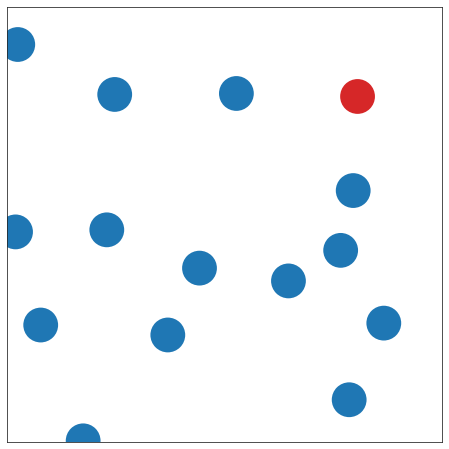

In [11]:
from matplotlib import collections
from matplotlib.animation import FuncAnimation
from matplotlib import animation

sns.set_style('white')
colors = sns.color_palette()
color_mapping = {State.SUSCEPTIBLE:colors[0],
                 State.INFECTIOUS:colors[3],
                 State.RECOVERED:colors[2],
                }


fig, ax = plt.subplots()
ax.set_xlim(model.space.x_min, model.space.x_max)
ax.set_ylim(model.space.y_min, model.space.y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

# we are using circles and a PatchCollection instead 
# of a scatter plot because this allows us to draw 
# the radius is data coordinates.
circles = [plt.Circle(agent.pos, radius=agent.radius, facecolor=color_mapping[agent.state],
                      linewidth=0) for agent in model.schedule.agents]
collection = collections.PatchCollection(circles, match_original=True)
ax.add_collection(collection)

def update(frame):
    model.step()
    circles = [plt.Circle(agent.pos, radius=agent.radius, linewidth=0) for agent in model.schedule.agents]
    
    colors = []
    for circle, agent in zip(circles, model.schedule.agents):
        circle.center = agent.pos
        colors.append(color_mapping[agent.state])

    collection.set_paths(circles)
    collection.set_facecolors(colors)
        
        
    return collection

In [12]:
from IPython.display import HTML
anim = FuncAnimation(fig, update, frames=1000, interval=40);
HTML(anim.to_html5_video())

In [18]:
model = InfectionModel(100, 100, 100, radius=1, seed=123456)
agents = model.schedule.agents
agents[0].state = State.INFECTIOUS # we start with 1 sick agent

In [19]:
%%timeit
for _ in range(100):
    model.step()

3.58 s ± 96.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
